## Code to generate figures for the Williams & Renwick paper on weather regimes over Aotearoa New Zealand

In [200]:
import iris

In [1010]:
import warnings
warnings.filterwarnings('ignore')
import iris
import scipy.ndimage
import random
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import cf_units
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import cartopy


from matplotlib.transforms import Affine2D


from sklearn.manifold import TSNE
import cartopy.feature as cfeature
import itertools
import iris.plot as iplt

import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
from scipy.spatial import ConvexHull
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import kde

import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import KMeans
import os.path
from braceexpand import braceexpand
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
#import mpl_toolkits.basemap as bm
from matplotlib import gridspec
import glob
from iris.time import PartialDateTime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import copy 
import matplotlib.ticker as mticker
from IPython.display import Image
import matplotlib.image as mpimg
from IPython.core.display import HTML 
import numpy as np
from iris.experimental.equalise_cubes import equalise_attributes
from eofs.iris import Eof
import cartopy.crs as ccrs
iris.FUTURE.cell_datetime_objects = True
import mo_pack
import time
from tqdm import tqdm
from tqdm import tqdm_gui
from tqdm import notebook
from tqdm import tqdm
import matplotlib

In [202]:
def get_contrast_color(hex_color):
    """
    Util function to know if it's best to use a white or a black color on the foreground given in parameter

    :param str hex_color: the foreground color to analyse
    :return: A black or a white color
    """
    r1 = int(hex_color[1:3], 16)
    g1 = int(hex_color[3:5], 16)
    b1 = int(hex_color[5:7], 16)

    # Black RGB
    black_color = "#000000"
    r2_black_color = int(black_color[1:3], 16)
    g2_black_color = int(black_color[3:5], 16)
    b2_black_color = int(black_color[5:7], 16)
    
    # Calc contrast ratio
    l1 = 0.2126 * pow(r1 / 255, 2.2) + 0.7152 * pow(g1 / 255, 2.2) + 0.0722 * pow(b1 / 255, 2.2)

    l2 = 0.2126 * pow(r2_black_color / 255, 2.2) + 0.7152 * pow(g2_black_color / 255, 2.2) + 0.0722 * pow(b2_black_color / 255, 2.2)

    if l1 > l2:
        contrast_ratio = int((l1 + 0.05) / (l2 + 0.05))
    else:
        contrast_ratio = int((l2 + 0.05) / (l1 + 0.05))
    
    # If contrast is more than 5, return black color
    if contrast_ratio > 5:
        return '#000000'
    # if not, return white color
    return '#FFFFFF'

In [1011]:
def rainbow_text(x, y, strings, colors, orientation='horizontal',
                 ax=None, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    for s, c in zip(strings, colors):
        text = ax.text(x, y, s + " ", color=c, transform=t, **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        if orientation == 'horizontal':
            t = text.get_transform() + Affine2D().translate(ex.width, 0)
        else:
            t = text.get_transform() + Affine2D().translate(0, ex.height)


In [203]:
import mpl_toolkits.basemap as bm

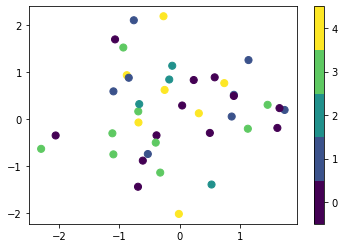

In [204]:
# By Jake VanderPlas
# License: BSD-style

#from https://gist.github.com/jakevdp/91077b0cae40f8f8244a

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    #
    #following is the original line from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    #return base.from_list(cmap_name, color_list, N)
    #
    #use following line if using perceptually uniform colour maps 
    return LinearSegmentedColormap.from_list(cmap_name, color_list, N)

#example

N = 5

x = np.random.randn(40)
y = np.random.randn(40)
c = np.random.randint(N, size=40)

# Edit: don't use the default ('jet') because it makes @mwaskom mad...
plt.scatter(x, y, c=c, s=50, cmap=discrete_cmap(N, 'viridis'))
plt.colorbar(ticks=range(N))
plt.clim(-0.5, N - 0.5)
plt.show();

In [205]:
latmin = -55
latmax = -25
lonmin = 160
lonmax = 185

In [206]:
#constants and invariants
g = 9.81
R = 287.
neofs = 5
nclusters = 12
n_init=200
random_state=42
n_jobs = -1
zoomfactor = 100
regimes = ['T', 'SW', 'TNW', 'TSW', 'H', 'HNW', 'W', 'HSE', 'HE', 'NE', 'HW', 'R']

In [207]:
#defining some map attributes
crs_latlon = ccrs.PlateCarree()
cmap = plt.get_cmap('plasma')
cmap_r = plt.get_cmap('plasma_r')
cmap_diff = plt.get_cmap('bwr')
cmap_diff_r = plt.get_cmap('bwr_r')

In [208]:
#pmsl, the esm runs don't have geopotential height at 12 hourly resolution but since
#the methodology talks about
#geopotential height at 1000hpa being analogous to pmsl i guess this is fine...
_1000hPa_air_pressure = iris.Constraint(air_pressure=1000.0)
_1000hPa_pressure = iris.Constraint(pressure=1000.0)
pmsl_constraint = iris.AttributeConstraint(STASH='m01s16i222')#pmsl
u_constraint = iris.AttributeConstraint(STASH='m01s30i201')#u on pressure levels
v_constraint = iris.AttributeConstraint(STASH='m01s30i202')#v on pressure levels
time_constraint = iris.Constraint(time=lambda t: t.point.hour in [0,12])
temperature_constraint = iris.AttributeConstraint(STASH='m01s03i236')#1.5m t
precip_constraint = iris.AttributeConstraint(STASH='m01s05i216')#total precip
isccp_constraint = iris.AttributeConstraint(STASH='m01s02i334')
_2204_constraint = iris.AttributeConstraint(STASH='m01s02i204')

In [209]:
latmin_agrif = -60.17
latmax_agrif = -10.75
lonmin_agrif= 132.70
lonmax_agrif= 180 + ( 180 - 143.7 )

In [210]:
_6h_cell_method = iris.coords.CellMethod(method='mean', coords='time', intervals='6 hour')
_6h_cell_method_constraint = iris.Constraint(cube_func=lambda cube: _6h_cell_method in cube.cell_methods)

_1h_cell_method = iris.coords.CellMethod(method='mean', coords='time', intervals='1 hour')
_1h_cell_method_constraint = iris.Constraint(cube_func=lambda cube: _1h_cell_method in cube.cell_methods)


In [211]:
#adapted from https://github.com/matplotlib/matplotlib/commit/4748f6f82442a18d3bf149245c42ab520f309914 which 
#was in response to my issue https://github.com/matplotlib/matplotlib/issues/18974

def fmt(x):
    s = f"{x:.2f}"
    if s.endswith("0") and s[2] == '0':
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

## kidson types

## ncep reanalysis data (geopotential height)

In [1969]:
height = {}
wind = {}

In [1970]:
height['ncepncar'] = iris.load_cube('ncepncar/hgt.nc',_1000hPa_air_pressure & time_constraint).intersection(
                                                                              latitude=(latmin,latmax), 
                                                                              longitude=(lonmin,lonmax))

In [1971]:
wind['ncepncar_uwind'] = iris.load_cube('ncepncar/uwnd.nc',_1000hPa_air_pressure & time_constraint).intersection(
                                                                              latitude=(latmin,latmax), 
                                                                              longitude=(lonmin,lonmax))

In [1972]:
wind['ncepncar_vwind'] = iris.load_cube('ncepncar/vwnd.nc',_1000hPa_air_pressure & time_constraint).intersection(
                                                                              latitude=(latmin,latmax), 
                                                                              longitude=(lonmin,lonmax))

In [1973]:
time = height['ncepncar'].coord('time')
dates = time.units.num2date(time.points)
#example format
print('hour format is like this... '+str(dates[0].hour))
print('day format is like this... '+str(dates[0].day))
print('month format is like this... '+str(dates[0].month))
print('year format is like this... '+str(dates[0].year))

hour format is like this... 0
day format is like this... 1
month format is like this... 1
year format is like this... 1958


In [1968]:
dates[-1]

cftime.DatetimeGregorian(1997-06-30 12:00:00)

In [1153]:
height['_ncepncar'] = height['ncepncar'][[i for i in range(height['ncepncar'][:].shape[0])
                    if time.units.num2date(height['ncepncar'][i].coord('time').points)[0].year < 1998]]

In [1154]:
wind['_ncepncar_uwind'] = wind['ncepncar_uwind'][[i for i in range(wind['ncepncar_uwind'][:].shape[0])
                    if time.units.num2date(wind['ncepncar_uwind'][i].coord('time').points)[0].year < 1998]]

In [1155]:
wind['_ncepncar_vwind'] = wind['ncepncar_vwind'][[i for i in range(wind['ncepncar_vwind'][:].shape[0])
                    if time.units.num2date(wind['ncepncar_vwind'][i].coord('time').points)[0].year < 1998]]

need to ignore dates after june 1997 as in kidson, 2000

In [1158]:
days_in_july_to_december_times_two_in_1997 = 2 * (31 + 31 +30 + 31 + 30 + 31)

In [1159]:
iris.save(height['_ncepncar'][0:-days_in_july_to_december_times_two_in_1997],'./ncepncar/height.nc')

In [1160]:
iris.save(wind['_ncepncar_uwind'][0:-days_in_july_to_december_times_two_in_1997],'./ncepncar/uwind.nc')

In [1161]:
iris.save(wind['_ncepncar_vwind'][0:-days_in_july_to_december_times_two_in_1997],'./ncepncar/vwind.nc')

## let's do the stats k2k! 

In [1974]:
dataset = 'ncepncar'

In [1975]:
if dataset == 'ncepncar':
    height = iris.load_cube('./ncepncar/height.nc')
    uwind = iris.load_cube('./ncepncar/uwind.nc')
    vwind = iris.load_cube('./ncepncar/vwind.nc')
    


In [1976]:
time = height.coord('time')
dates = time.units.num2date(time.points)

add lat and lon bounds if need be

In [1977]:
if height.coord('latitude').has_bounds() == False:
    height.coord('latitude').guess_bounds()
  
if  height.coord('longitude').has_bounds() == False:
    height.coord('longitude').guess_bounds() 

'standardise' the matrix, i.e. remove the mean and divide by the standard deviation

In [1978]:
height_standardised = copy.deepcopy(height)

In [1979]:
standardise_heights = True

if standardise_heights:
    height_standardised.data = ( height.data - \
                                     np.mean(height.data, axis=0) )

In [1980]:
solver = Eof ( height_standardised, weights = None )

plot fraction of variance explaned by each eof as a fn of eof

In [1981]:
 np.sum(Eof(height_standardised, weights=None).varianceFraction(neigs = neofs).data)

0.9316351

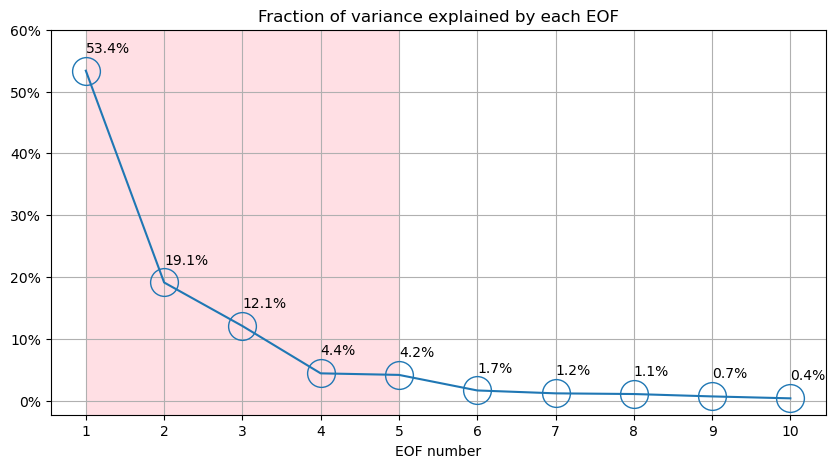

In [2411]:
plot_variance_explained_as_fun_of_neofs = True

if plot_variance_explained_as_fun_of_neofs:

    fig = plt.figure(figsize=[10,5])

    plt.plot(np.arange(10)+1, Eof(height_standardised, weights=None).varianceFraction(neigs = 10).data,'-o',
             fillstyle='none', markersize = 20)
    plt.grid()
    plt.xlabel('EOF number')
    #plt.ylabel('Fraction of variance\n explained by each EOF')
    plt.title('Fraction of variance explained by each EOF')
    plt.xticks(np.arange(10)+1)
    plt.yticks([0,.1,.2,.3,0.4,.5,.6])
#     plt.xlim([0,10])
    
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    
    plt.axvspan(1, 5, color='pink', alpha=0.5, lw=0)
    
    for i in range(10):
    
        plt.gca().text(i+1,Eof(height_standardised, weights=None).varianceFraction(neigs = 10).data[i] + 0.03,
                   "{:.1f}".format(Eof(height_standardised,
                                       weights=None).varianceFraction(neigs = 10).data[i]*100) + '%')
                  
    
#     plt.text(Eof(height_standardised, weights=None).varianceFraction(neigs = 10).data[0]*100,
#             1, 0.5)
    
plt.savefig('./ncepncar/frac-var-explained.pdf')    
    
plt.show();

In [2265]:
np.sum(Eof(height_standardised, weights=None).varianceFraction(neigs = 5).data)

0.9316351

In [2252]:
"{:.2f}".format(val)

'0.53'

In [1983]:
neofs = 5

In [1984]:
npcs = copy.copy(neofs)
eofs = solver.eofs(neofs = neofs)
pcs = solver.pcs(npcs = npcs, pcscaling=0)
varianceFraction = solver.varianceFraction(neigs = neofs).data
print(np.sum(varianceFraction))

0.9316351


In [2044]:
varianceFraction

array([0.5337395 , 0.19119373, 0.12080758, 0.04420606, 0.04168817],
      dtype=float32)

In [1985]:
pcs_norm = copy.deepcopy(pcs)

for i in range(pcs.data.shape[0]):
    pcs_norm.data[i] = (pcs.data[i] - np.mean(pcs.data[i], axis = 0 ))/np.std(pcs.data[i], axis= 0)

In [1987]:
dataset

'ncepncar'

In [1989]:
#define spatial coordinate axes

latitude = eofs.coord('latitude').points
longitude =  eofs.coord('longitude').points
lats, lons = np.meshgrid(latitude,longitude)

100%|██████████| 5/5 [00:39<00:00,  7.83s/it]


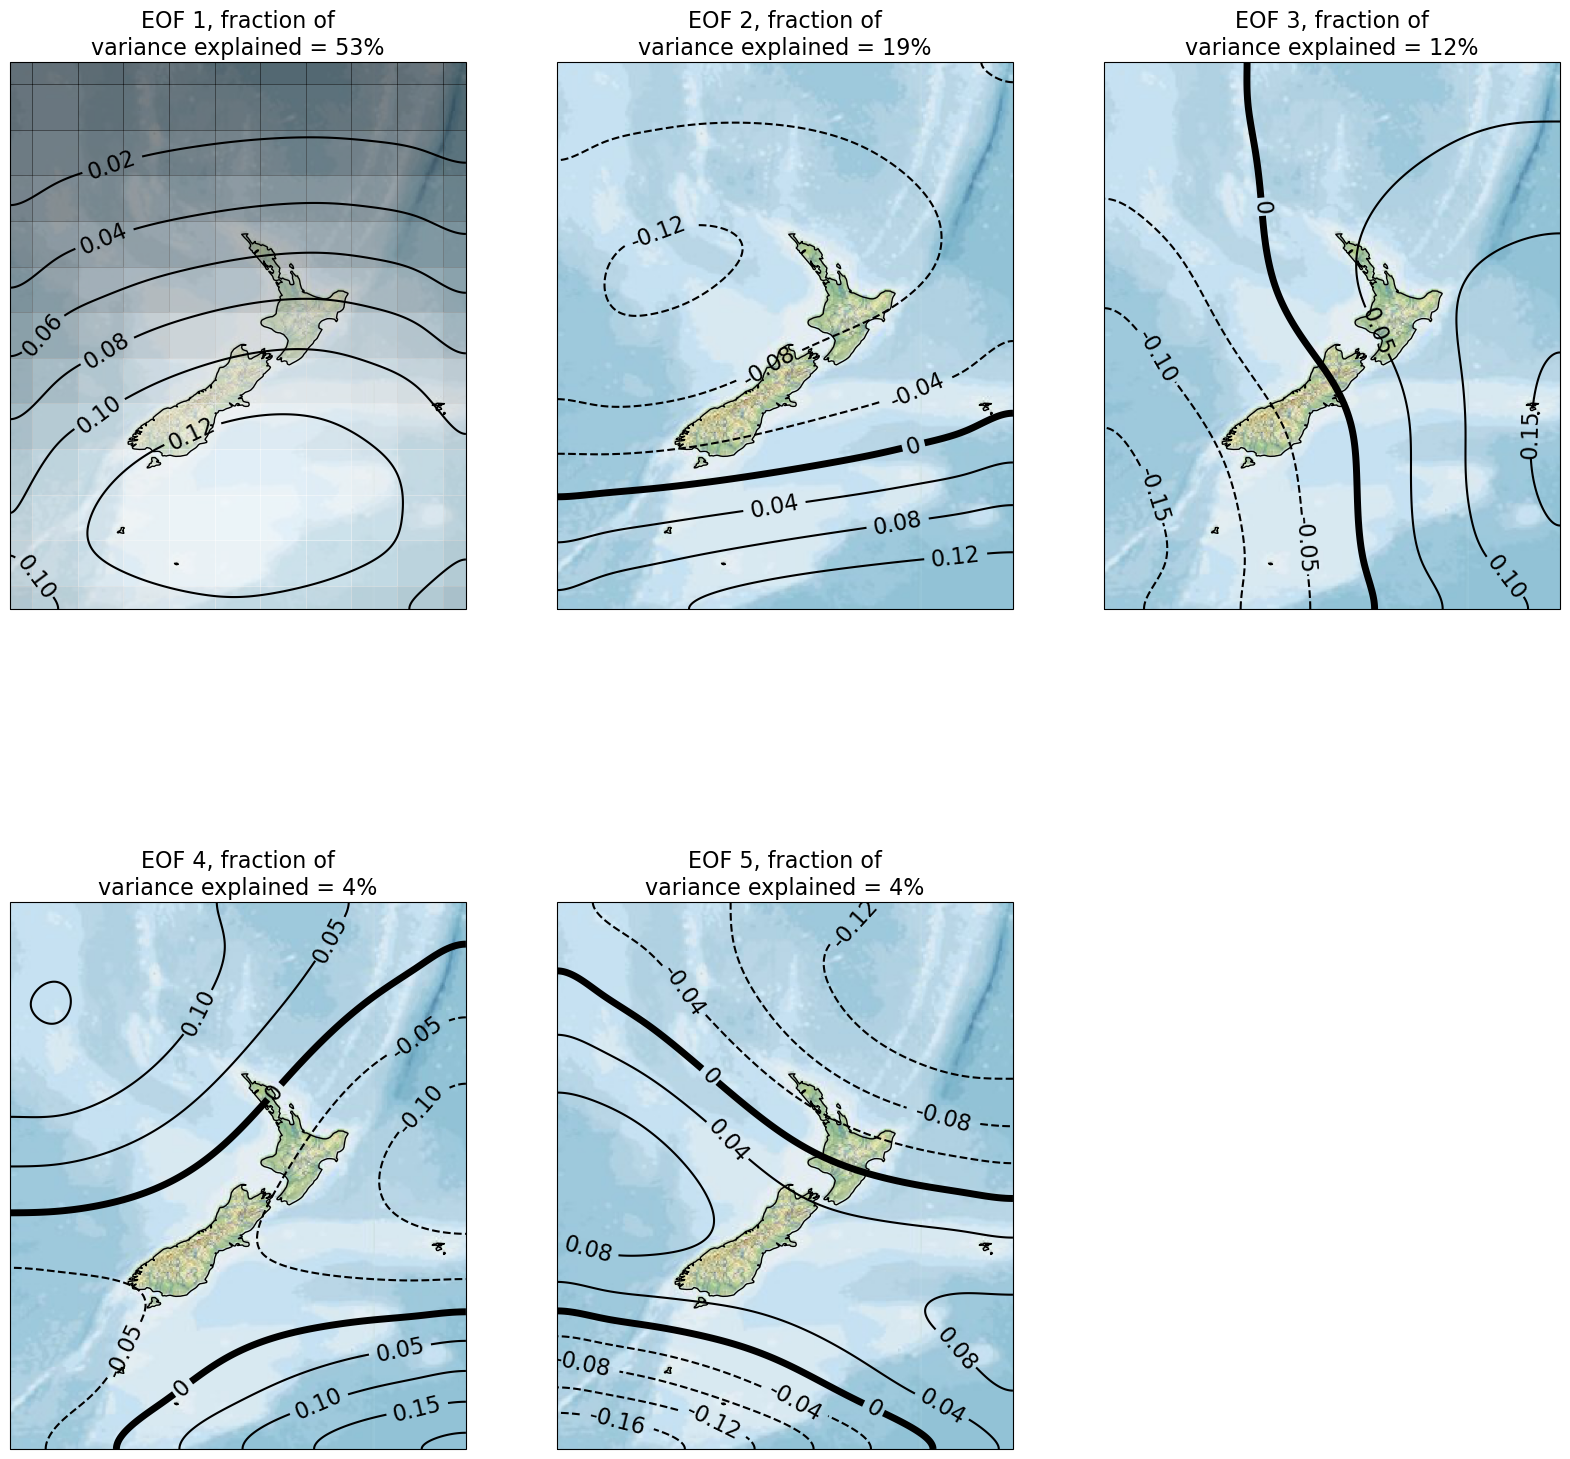

In [2412]:
fig = plt.figure(figsize=[20,20])

for i in tqdm(range(neofs)):

    ax = plt.subplot(2,3,i+1,projection=ccrs.PlateCarree(central_longitude=180), aspect='auto')
    ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs = crs_latlon)
    ax.coastlines()
    
    if i == 0:
        iplt.pcolormesh(eofs[i], cmap = 'Greys_r', alpha = 0.5)
        #plt.colorbar()

    #########################################################################################################
    #smooth contours
       
    smooth_contours = True
    
    if smooth_contours:
   
        sample_points = [('longitude', np.linspace(lonmin, lonmax, int(longitude.shape[0]*zoomfactor))),
                         ('latitude',  np.linspace(latmax, latmin, int(latitude.shape[0]*zoomfactor)))]

        interpolate = copy.deepcopy(eofs[i]).interpolate(sample_points,
                                                                    iris.analysis.Linear())
        zoom = scipy.ndimage.zoom(eofs[i].data, zoomfactor)
        interpolate.data = zoom.data

        contours = iplt.contour(interpolate, colors = 'k')
        contours.collections[int(np.array(np.where(contours.levels == 0)))].set_linewidth(5) 

        labels = ax.clabel(contours, contours.levels[:], inline=True, fmt=fmt, fontsize=16)
    
   
    else:
        contours = iplt.contour(eofs[i],colors='k')
        ax.clabel(contours, contours.levels[::2], inline=True, fmt=fmt, fontsize=16)
                        
    #######################################################################################################
    
    plt.title('EOF '+str(i + 1)+', fraction of\nvariance explained = '+
              str(int(varianceFraction[i]*100))+'%', fontsize = 16)
        
   
    ax.background_img(name='plate-carree-wikipedia', resolution='low')
    #ax.stock_img()
    
if dataset =='ncepncar':
    plt.savefig('./ncepncar/eofs.pdf')
    
plt.show();

In [1991]:
#do the k-means clustering
kmeans = KMeans(init='k-means++',
                n_clusters=nclusters,
                n_init=n_init,
                n_jobs=n_jobs,
                random_state=random_state)

kmeans.fit(pcs_norm.data)

KMeans(n_clusters=12, n_init=200, n_jobs=-1, random_state=42)

In [2267]:
kmeans.max_iter

300

In [1992]:
indices = np.array(kmeans.labels_.data)

In [1993]:
height_clusters = []
pc_clusters = []
uwind_clusters = []
vwind_clusters = []

for i in tqdm(range(nclusters)):
    height_clusters.append(height[np.where(indices == i)].collapsed('time', iris.analysis.MEAN))
    pc_clusters.append(pcs[np.where(indices == i)].collapsed('time', iris.analysis.MEAN))
    uwind_clusters.append(uwind[np.where(indices == i)].collapsed('time', iris.analysis.MEAN))
    vwind_clusters.append(vwind[np.where(indices == i)].collapsed('time', iris.analysis.MEAN))
    
    


100%|██████████| 12/12 [00:00<00:00, 43.41it/s]


In [1994]:
kmeans_fractions = []

for i in range(nclusters):
    kmeans_fractions.append(height[indices == i].data.shape[0] / height.data.shape[0])

In [1995]:
cluster_centers = kmeans.cluster_centers_

In [1996]:
#reorder the cluster to match with k2k

reorder = True

if reorder:
    
    print('reordering')
    
    height_clusters_k2k_order = copy.deepcopy(height_clusters)
    pc_clusters_k2k_order = copy.deepcopy(pc_clusters)
    kmeans_fractions_k2k_order = copy.deepcopy(kmeans_fractions)
    cluster_centers_k2k_order = copy.deepcopy(cluster_centers)
    uwind_clusters_k2k_order = copy.deepcopy(uwind_clusters)
    vwind_clusters_k2k_order = copy.deepcopy(vwind_clusters)
    
#     neworder = np.array([6,9,10,1,7,0,4,2,11,3,5,8])
    neworder = np.array([6,9,10,1,7,0,4,2,11,3,8,5])

    
    for i in range(nclusters):
        height_clusters_k2k_order[i] = height_clusters[neworder[i]]
        pc_clusters_k2k_order[i] = pc_clusters[neworder[i]]
        kmeans_fractions_k2k_order[i] = kmeans_fractions[neworder[i]]
        cluster_centers_k2k_order[i] = cluster_centers[neworder[i]]
        uwind_clusters_k2k_order[i] = uwind_clusters[neworder[i]]
        vwind_clusters_k2k_order[i] = vwind_clusters[neworder[i]]
    
    height_clusters = copy.deepcopy(height_clusters_k2k_order)
    pc_clusters = copy.deepcopy(pc_clusters_k2k_order)
    kmeans_fractions = copy.deepcopy(kmeans_fractions_k2k_order)
    cluster_centers = copy.deepcopy(cluster_centers_k2k_order)
    uwind_clusters = copy.deepcopy(uwind_clusters_k2k_order)
    vwind_clusters = copy.deepcopy(vwind_clusters_k2k_order)
    
else:
    print('not reordering')

reordering


In [1997]:
dataset

'ncepncar'

In [1998]:
if dataset == 'ncepncar':
    iris.save(height_clusters,'./ncepncar/clusters.nc')
    iris.save(pc_clusters,'./ncepncar/pc_clusters.nc')


## sensitivity of clusters to number of iterations used in k-means clustering

100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


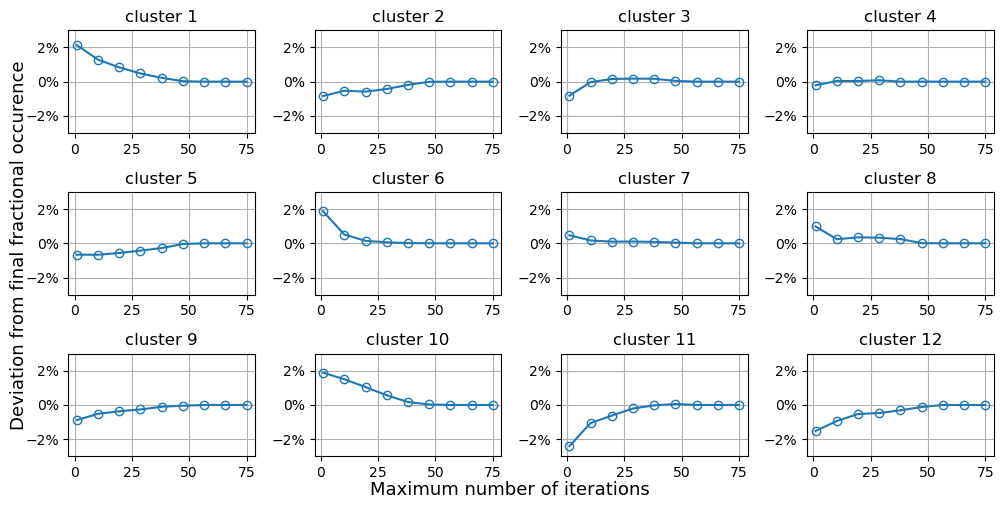

In [2417]:
niter = 9

max_iter_array = np.linspace(1,75,niter)

_kmeans_fractions_array = []

for i in tqdm(range(niter)):
       
    _kmeans =   KMeans(init='k-means++',
                n_clusters=nclusters,
                n_init=1,
                max_iter=int(max_iter_array[i]),
                random_state=random_state)

    _kmeans.fit(pcs_norm.data)
    
    _kmeans_fractions = []

    for l in range(nclusters):
        _kmeans_fractions.append(height[_kmeans.labels_ == l].data.shape[0] / height.data.shape[0])    

    _kmeans_fractions_array.append(_kmeans_fractions)    
        

_kmeans_fractions_array = np.array(_kmeans_fractions_array)
    
plt.figure(figsize=[10,5])

for i in range(nclusters):
    
    plt.subplot(3,4,i+1)
    
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1,decimals=0))

    plt.plot(max_iter_array, _kmeans_fractions_array[:,i] - _kmeans_fractions_array[-1,i],'o-',
             fillstyle = 'none')

    plt.ylim([-.03,.03])
    plt.grid()
    plt.title('cluster '+str(i+1))

plt.gcf().text(0,0.5,'Deviation from final fractional occurence', rotation = 90,
               fontsize = 13, verticalalignment = 'center')

plt.gcf().text(0.5,0,'Maximum number of iterations', rotation = 0,
               fontsize = 13, horizontalalignment = 'center')
    
plt.tight_layout()

plt.savefig('./ncepncar/devfromfinal.pdf')

plt.show();
    

In [2309]:
np.max(_kmeans_fractions_array - _kmeans_fractions_array[-1], axis=1)

array([0.01504228, 0.01050187, 0.00623874, 0.00391654, 0.00152502,
       0.00020796, 0.        , 0.        , 0.        ])

In [2024]:
#example of what np.linalg.norm actually means
np.linalg.norm(projection[-2,:] - pc_clusters[0].data) == \
np.sqrt(np.sum(abs(projection[-2,:] - pc_clusters[0].data)**2))

True

In [2025]:
np.linalg.norm(projection[-2,:] - pc_clusters[0].data)
np.sqrt(np.sum(abs(projection[-2,:] - pc_clusters[0].data)**2))

4.016381

4.016381

In [2026]:
plotthisindex = int(np.argmin(distances_all_array)/12) + 1


In [2047]:
dates[plotthisindex]

cftime.DatetimeGregorian(1997-04-06 00:00:00)

100%|██████████| 12/12 [02:47<00:00, 14.00s/it]


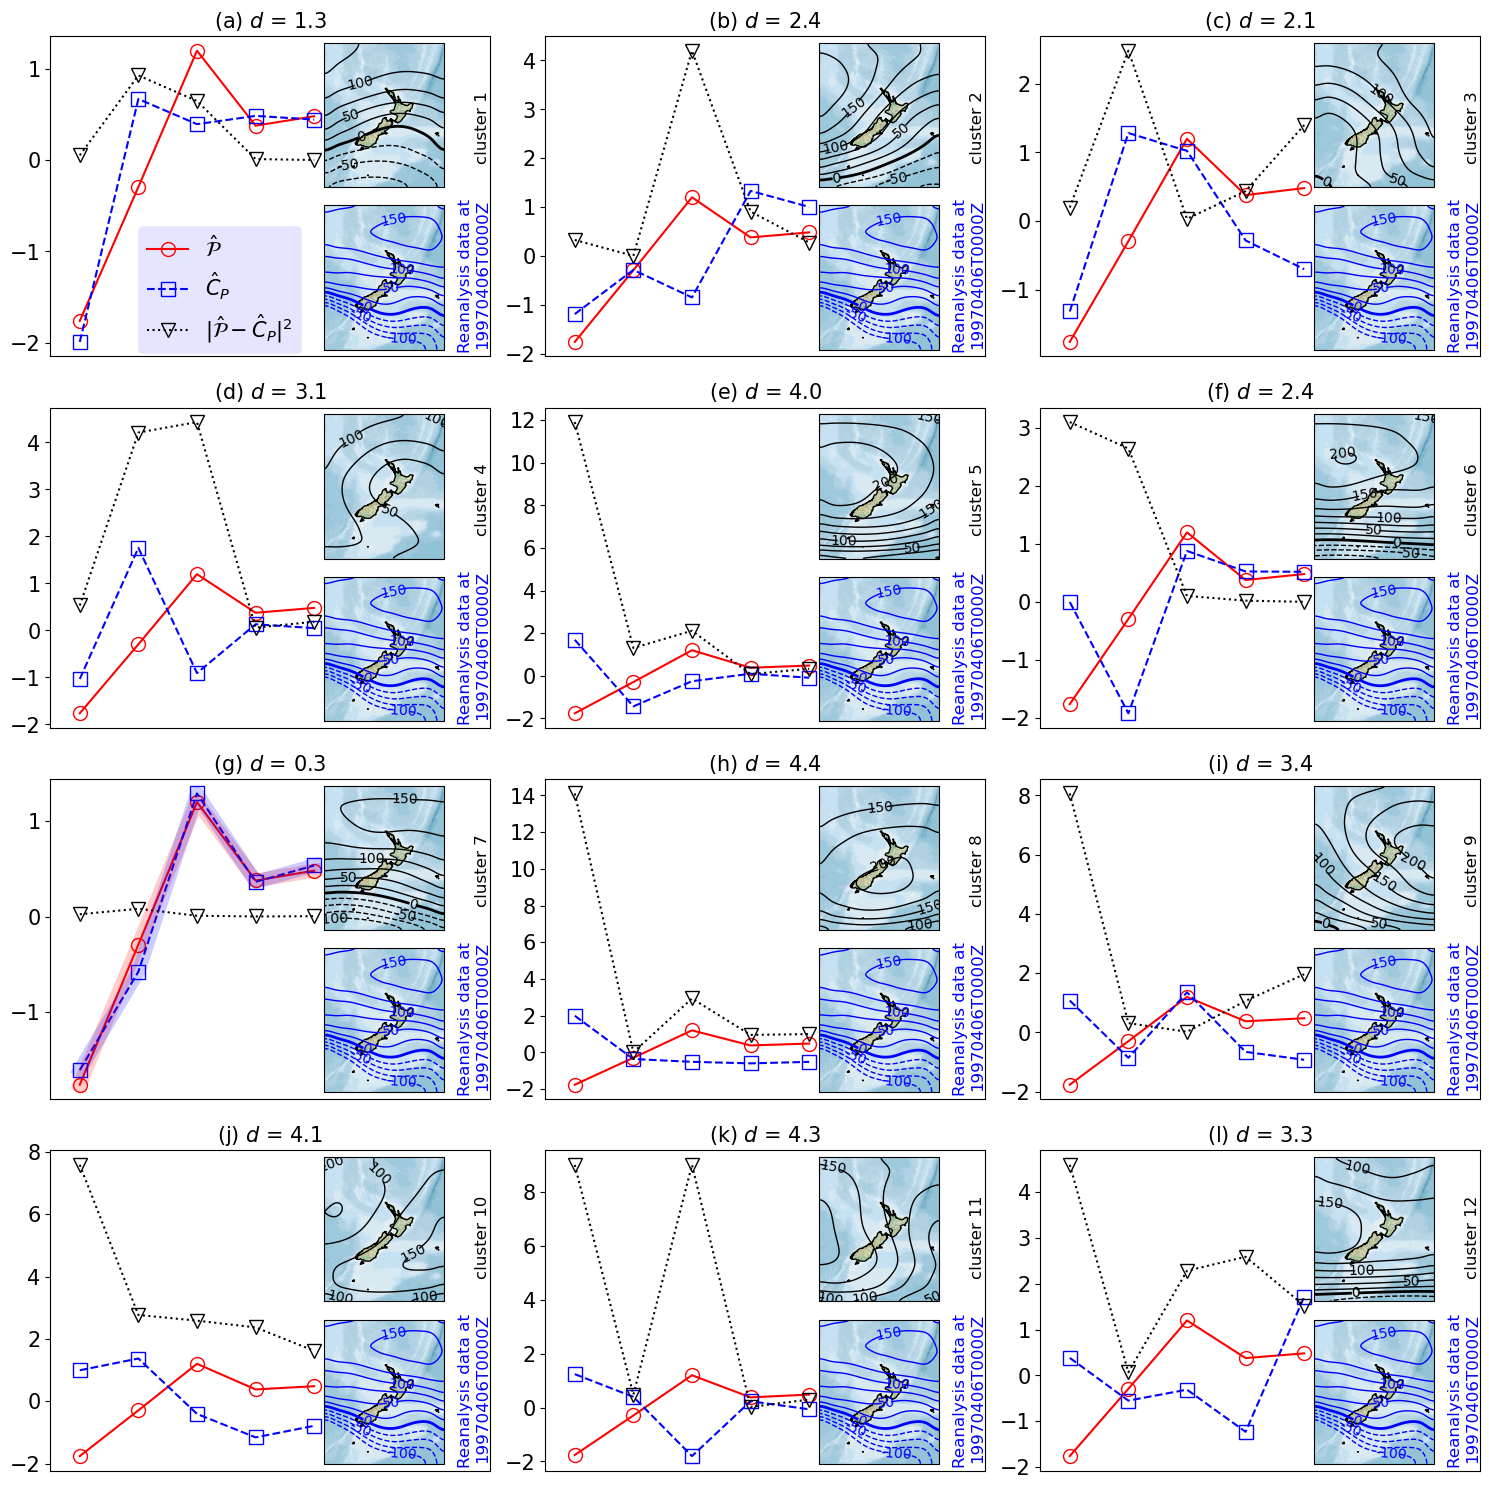

In [2418]:
fig = plt.figure(constrained_layout=True, figsize=[15,15])

markersize = 10

letters = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ','(i) ','(j) ','(k) ','(l) ']

for i in tqdm(range(12)):
    plt.subplot(4,3,i+1)
    plt.plot(np.linspace(1,neofs,neofs), projection[plotthisindex,:] ,'-or', label = r'$\hat{\mathcal{P}}$',
            markersize = markersize, fillstyle = 'none')
    plt.plot(np.linspace(1,neofs,neofs), pc_clusters[i].data,'--sb', label = r'$\hat{C}_P$',
            markersize = markersize, fillstyle = 'none')
    plt.plot(np.linspace(1,neofs,neofs),abs(projection[plotthisindex,:] - pc_clusters[i].data)**2,':vk',
             label = r'$\left|\hat{\mathcal{P}}- \hat{C}_P\right|^2$',markersize = markersize,
             fillstyle = 'none')
    
    
    if i == 6:
        plt.plot(np.linspace(1,neofs,neofs), projection[plotthisindex,:],'-r',
                 label = r'$\hat{\mathcal{P}}$', linewidth = 10, alpha = 0.2)
        plt.plot(np.linspace(1,neofs,neofs), pc_clusters[i].data,'-b',
                 label = r'$\hat{C}_P$', linewidth = 10, alpha = 0.2)


    
    d = np.sqrt(np.sum(abs(projection[-1,:] - pc_clusters[i].data)**2))
    plt.title(letters[i]+r'$d$ = '+
              str("{:.1f}".format(np.sqrt(np.sum(abs(projection[plotthisindex,:] - pc_clusters[i].data)**2)))),
             fontsize = 15)
    
    if i == 0:
        plt.legend(fontsize = 15, loc = (0.2,0.01),
                   facecolor = 'b', framealpha = 0.1)#, bbox_to_anchor = (0.55, 0.5))
        
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.xlim([0.5,8])
#     plt.ylim(bottom=-3)
    
    #ax.spines['top'].set_visible(True)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(True)    
    
    ax.get_xaxis().set_ticks([])
    
       
    ax.tick_params(axis='both', which='major', labelsize=15)

    if i <= np.infty:
#     if i ==0:    

        #########################################################################################################
        axins = inset_axes(ax, width="45%", height="45%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree(central_longitude=180),
                                        aspect='auto'))
        axins.coastlines()

        levels = np.array([-100,-75,-50,-25,0,25,50,75,100,125,150,175,200]);


        sample_points = [('longitude', np.linspace(lonmin, lonmax, int(longitude.shape[0]*zoomfactor))),
                         ('latitude',  np.linspace(latmax, latmin, int(latitude.shape[0]*zoomfactor)))]

        interpolate = copy.deepcopy(height_clusters[i]).interpolate(sample_points,
                                                                    iris.analysis.Linear())
        zoom = scipy.ndimage.zoom(height_clusters[i].data, zoomfactor)
        interpolate.data = zoom.data

        contours = iplt.contour(interpolate, colors = 'k', levels = levels, linewidths = 1)
        contours.collections[int(np.array(np.where(levels == 0)))].set_linewidth(2) 
        plt.clabel(contours, contours.levels[::2], inline=True, fmt='%d', fontsize=10);

#         plt.title('cluster '+str(i))

#         props = dict(boxstyle='round', alpha=1, facecolor = 'w')
# #         axins.text(0.6, 0.95, 'cluster '+str(i), transform=ax.transAxes, fontsize=10,
# #                   verticalalignment='top', horizontalalignment = 'right', bbox=props)
#         axins.text(1., 0, 'cluster '+str(i + 1), transform=ax.transAxes, fontsize=12,
#                   verticalalignment='top', horizontalalignment = 'left',rotation='vertical')#, bbox=props)


        axins.background_img(name='plate-carree-wikipedia', resolution='low')

        ###########################################################################################################


        axins = inset_axes(ax, width="45%", height="45%", loc="lower right", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree(central_longitude=180), aspect = 'auto'))
        axins.coastlines()

        sample_points = [('longitude', np.linspace(lonmin, lonmax, int(longitude.shape[0]*zoomfactor))),
                         ('latitude',  np.linspace(latmax, latmin, int(latitude.shape[0]*zoomfactor)))]

        interpolate = copy.deepcopy(height_clusters[i]).interpolate(sample_points,
                                                                    iris.analysis.Linear())
        zoom = scipy.ndimage.zoom(height[plotthisindex].data, zoomfactor)
        interpolate.data = zoom.data

        contours = iplt.contour(interpolate, colors = 'b', levels = levels, linewidths = 1)
        contours.collections[int(np.array(np.where(levels == 0)))].set_linewidth(2) 
        axins.clabel(contours, contours.levels[::2], inline=True, fmt='%d', fontsize=10)

#         plt.ylabel('foo')
#         plt.title('NCEP/NCAR\ndata at\n19970406T0000Z')
        
        if i >= 0:
            props = dict(boxstyle='round', alpha=0.5, facecolor = 'w')
#             axins.text(0.5, 0.05,'NCEP/NCAR\ndata at\n19970406T0000Z',
#                        transform=ax.transAxes, fontsize=10,
#                        verticalalignment='bottom', horizontalalignment = 'right', bbox=props, color = 'b')
            
            ax.text(1, 0.01,'Reanalysis data at\n19970406T0000Z',
                       fontsize=12,
                       verticalalignment='bottom', horizontalalignment = 'right', color = 'b',
                       rotation='vertical',transform=ax.transAxes)#, bbox=props)
            
            
            ax.text(1., 0.6, 'cluster '+str(i + 1),fontsize=12,
                  verticalalignment='bottom', horizontalalignment = 'right',rotation='vertical',
                   transform=ax.transAxes)#, bbox=props)
            

        axins.background_img(name='plate-carree-wikipedia', resolution='low')

plt.tight_layout()

plt.savefig('./ncepncar/geometry.pdf')

plt.show();

# k2k clusters from james

In [2028]:
f=open('from-james/cluster_means.txt')
lines=f.readlines()

In [2029]:
k2k_height_clusters_dict = {}

In [2030]:
k2k_height_clusters_dict['T'] = np.array(lines[2:17])
k2k_height_clusters_dict['SW'] = np.array(lines[18:33])
k2k_height_clusters_dict['TNW'] = np.array(lines[34:49])
k2k_height_clusters_dict['TSW'] = np.array(lines[50:65])
k2k_height_clusters_dict['H'] = np.array(lines[66:81])
k2k_height_clusters_dict['HNW'] = np.array(lines[82:97])
k2k_height_clusters_dict['W'] = np.array(lines[98:113])
k2k_height_clusters_dict['HSE'] = np.array(lines[114:129])
k2k_height_clusters_dict['HE'] = np.array(lines[130:145])
k2k_height_clusters_dict['NE'] = np.array(lines[146:161])
k2k_height_clusters_dict['HW'] = np.array(lines[162:177])
k2k_height_clusters_dict['R'] = np.array(lines[178:193])



In [2031]:
regimes = ['T','SW','TNW','TSW','H','HNW','W','HSE','HE','NE','HW','R']

for regime in regimes:

    _1d = []

    for i in range(len(array)):
        _1d.append(k2k_height_clusters_dict[regime][i].strip().split())

    _1d = np.array(_1d)
    
    k2k_height_clusters_dict[regime] = np.flipud(np.concatenate(_1d[:].flatten(), axis=0).\
                                              reshape(13,11).astype(np.float))
    
    

In [2032]:
k2k_height_clusters = copy.deepcopy(height_clusters)

In [2033]:
for i in range(nclusters):
    k2k_height_clusters[i].data = k2k_height_clusters_dict[regimes[i]]

In [2034]:
k2k_occurrences = [12.3, 11.3, 7.6, 7.3, 12.9, 6.9, 4.8, 13.7, 7.1,6.3,5.4,4.7]

In [1]:
mpl.rcParams.update(mpl.rcParamsDefault)

letters = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)']

fig = plt.figure(constrained_layout=True, figsize=[15,15], frameon=True)

plot_model_data = False

if plot_model_data:

    pass

else:
    
    gs = fig.add_gridspec(6, 8)
    
    gs_array=[[0, 0], [0,2], [0, 4], [0, 6],[2, 0], [2, 2], [2, 4], [2, 6], [4, 0], [4, 2], [4, 4], [4, 6]]
   
regime_family = ['trough', 'trough', 'trough', 'trough', 'zonal', 'zonal', 'zonal', 'blocking',
                'blocking', 'blocking', 'blocking','blocking']

regime_family_colour = ['darkorchid', 'darkorchid', 'darkorchid', 'darkorchid', 'lemonchiffon',
                        'lemonchiffon', 'lemonchiffon', 'deeppink',
                        'deeppink', 'deeppink', 'deeppink','deeppink']

regime_family_colour = ['w', 'w', 'w',
                             'w', 'w',
                             'w', 'w', 'w',
                             'w', 'w', 'w','w']

regime_family_text_colour = ['lightgoldenrodyellow', 'lightgoldenrodyellow', 'lightgoldenrodyellow',
                             'lightgoldenrodyellow', 'mediumorchid',
                             'mediumorchid', 'mediumorchid', 'mintcream',
                             'mintcream', 'mintcream', 'mintcream','mintcream']

regime_family_text_colour = ['k', 'k', 'k', 'k', 'k',
                        'k', 'k', 'k',
                        'k', 'k', 'k','k']



for i in tqdm(range(nclusters - 2)):
    
    
    ax = fig.add_subplot(gs[gs_array[i][0]:gs_array[i][0]+2*(i <= nclusters-1),
                            gs_array[i][1]:gs_array[i][1]+2*(i <= nclusters-1)], 
                         projection=ccrs.PlateCarree(central_longitude=180), aspect='auto')
    
    ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs = crs_latlon);
    ax.coastlines();
    
    levels = np.array([-100,-75,-50,-25,0,25,50,75,100,125,150,175,200]);

    plt.title(letters[i]+' '+regimes[i], fontsize = 20)    
    
    #########################################################################################################
    #smooth contours
   
    smooth_contours = True
    if smooth_contours:
        #new
        
        if i < nclusters - 2:
        
            sample_points = [('longitude', np.linspace(lonmin, lonmax, int(longitude.shape[0]*zoomfactor))),
                             ('latitude',  np.linspace(latmax, latmin, int(latitude.shape[0]*zoomfactor)))]

            interpolate = copy.deepcopy(height_clusters[i]).interpolate(sample_points,
                                                                        iris.analysis.Linear())
            zoom = scipy.ndimage.zoom(height_clusters[i].data, zoomfactor)
            interpolate.data = zoom.data

            contours = iplt.contour(interpolate, colors = 'k', levels = levels, alpha = 1)
            contours.collections[int(np.array(np.where(levels == 0)))].set_linewidth(5) 
            plt.clabel(contours,contours.levels[::2],  inline=True, fontsize=8, fmt='%d');
        #k2k
        sample_points = [('longitude', np.linspace(lonmin, lonmax, int(longitude.shape[0]*zoomfactor))),
                         ('latitude',  np.linspace(latmax, latmin, int(latitude.shape[0]*zoomfactor)))]

        interpolate = copy.deepcopy(k2k_height_clusters[i]).interpolate(sample_points,
                                                                    iris.analysis.Linear())
        zoom = scipy.ndimage.zoom(k2k_height_clusters[i].data, zoomfactor)
        interpolate.data = zoom.data

        contours = iplt.contour(interpolate, colors = 'b', levels = levels, alpha = 0.4)
        contours.collections[int(np.array(np.where(levels == 0)))].set_linewidth(5) 
        plt.clabel(contours, contours.levels[::2], inline=True, fontsize=8, fmt='%d', colors = 'b');
    else:
        
        pass
    

        
    
    ax.background_img(name='plate-carree-wikipedia', resolution='low')

   
if dataset == 'ncepncar':
     plt.savefig('./ncepncar/cluster_comparison.pdf')

        
plt.show();

NameError: name 'mpl' is not defined

## graphical abstract for ijoc

100%|██████████| 12/12 [01:23<00:00,  6.93s/it]


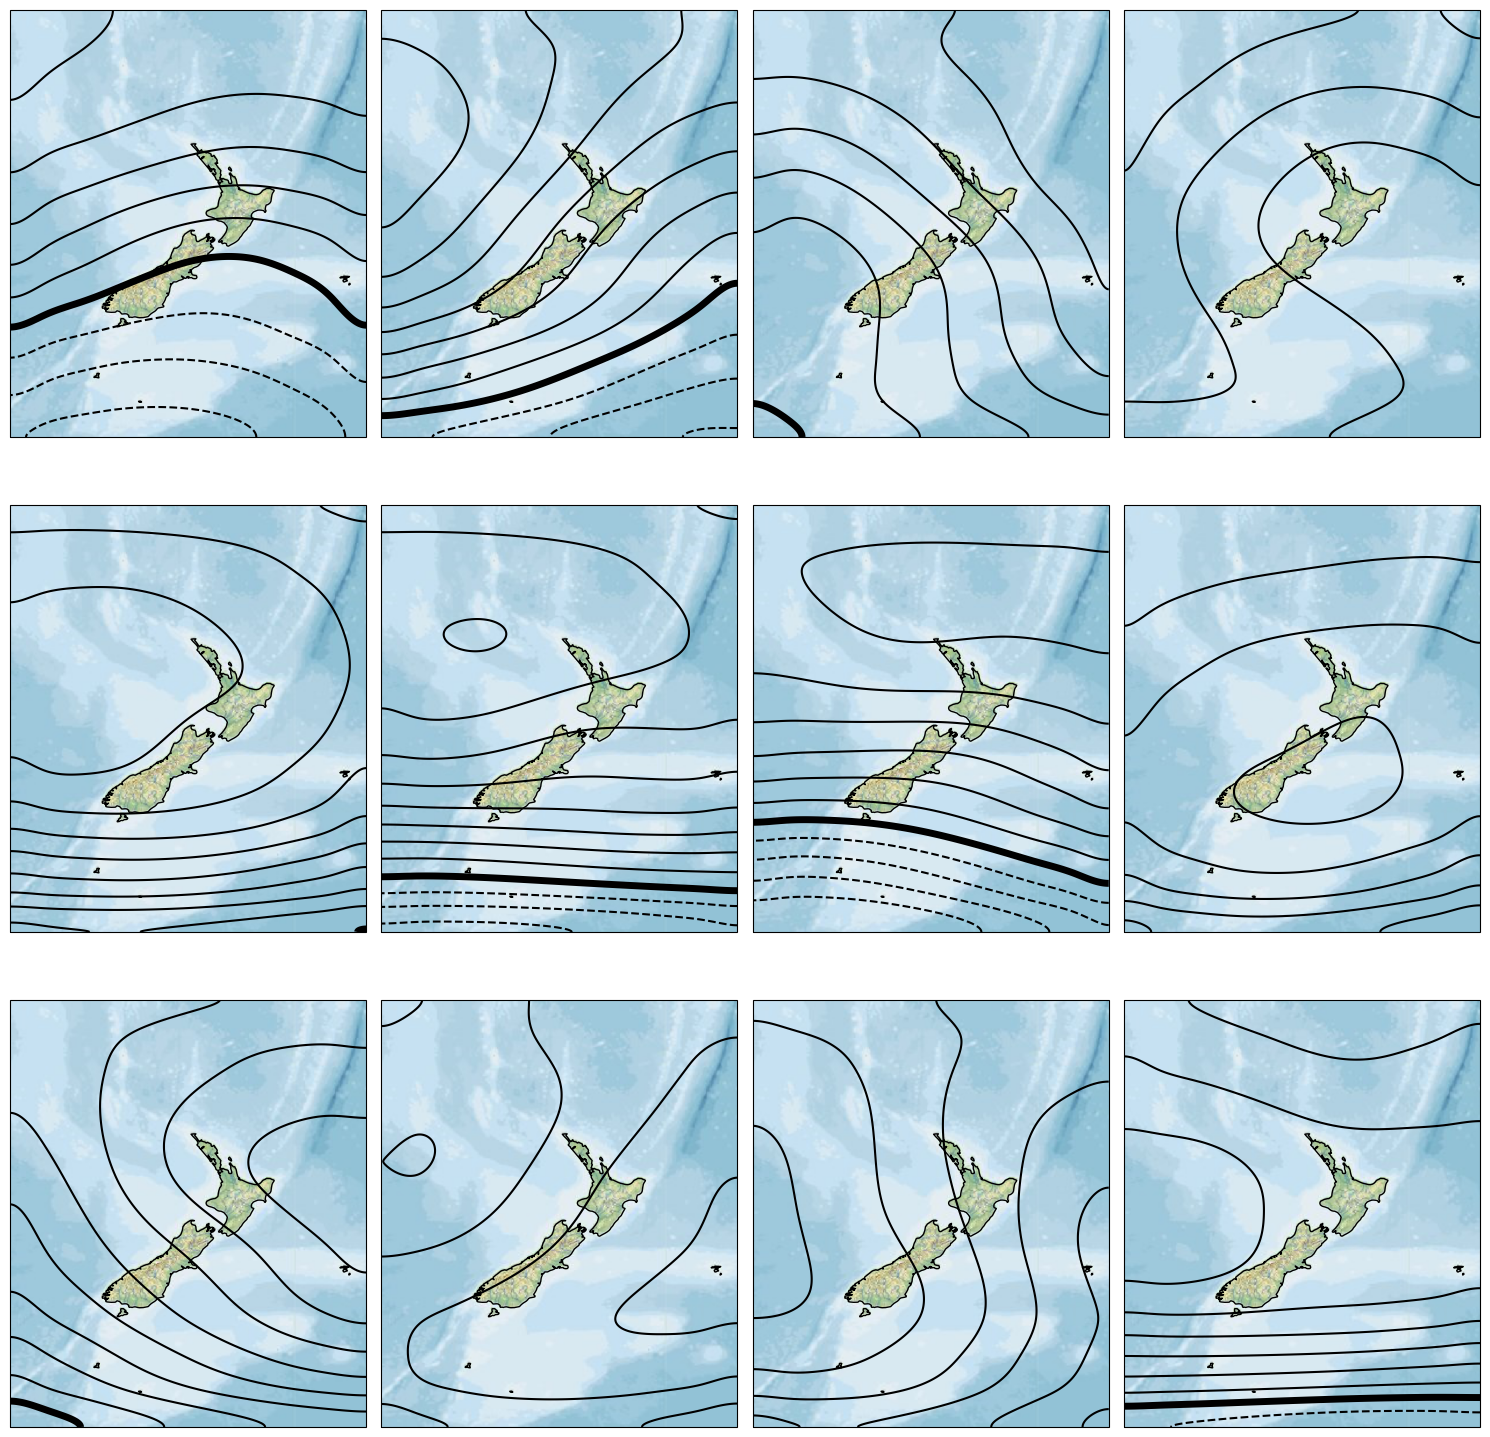

In [2419]:
mpl.rcParams.update(mpl.rcParamsDefault)

letters = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)']

fig = plt.figure(constrained_layout=True, figsize=[15,15], frameon=True)

plot_model_data = False

if plot_model_data:

    pass

else:
    
    gs = fig.add_gridspec(6, 8)
    
    gs_array=[[0, 0], [0,2], [0, 4], [0, 6],[2, 0], [2, 2], [2, 4], [2, 6], [4, 0], [4, 2], [4, 4], [4, 6]]
   
regime_family = ['trough', 'trough', 'trough', 'trough', 'zonal', 'zonal', 'zonal', 'blocking',
                'blocking', 'blocking', 'blocking','blocking']

regime_family_colour = ['darkorchid', 'darkorchid', 'darkorchid', 'darkorchid', 'lemonchiffon',
                        'lemonchiffon', 'lemonchiffon', 'deeppink',
                        'deeppink', 'deeppink', 'deeppink','deeppink']

regime_family_colour = ['w', 'w', 'w',
                             'w', 'w',
                             'w', 'w', 'w',
                             'w', 'w', 'w','w']

regime_family_text_colour = ['lightgoldenrodyellow', 'lightgoldenrodyellow', 'lightgoldenrodyellow',
                             'lightgoldenrodyellow', 'mediumorchid',
                             'mediumorchid', 'mediumorchid', 'mintcream',
                             'mintcream', 'mintcream', 'mintcream','mintcream']

regime_family_text_colour = ['k', 'k', 'k', 'k', 'k',
                        'k', 'k', 'k',
                        'k', 'k', 'k','k']



for i in tqdm(range(nclusters)):
    
    
    ax = fig.add_subplot(gs[gs_array[i][0]:gs_array[i][0]+2*(i <= nclusters-1),
                            gs_array[i][1]:gs_array[i][1]+2*(i <= nclusters-1)], 
                         projection=ccrs.PlateCarree(central_longitude=180), aspect='auto')
    
    ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs = crs_latlon);
    ax.coastlines();
    
    levels = np.array([-100,-75,-50,-25,0,25,50,75,100,125,150,175,200]);
    
    #########################################################################################################
    #smooth contours
   
    smooth_contours = True
    if smooth_contours:
        #new
        
        if i < nclusters:
        
            sample_points = [('longitude', np.linspace(lonmin, lonmax, int(longitude.shape[0]*zoomfactor))),
                             ('latitude',  np.linspace(latmax, latmin, int(latitude.shape[0]*zoomfactor)))]

            interpolate = copy.deepcopy(height_clusters[i]).interpolate(sample_points,
                                                                        iris.analysis.Linear())
            zoom = scipy.ndimage.zoom(height_clusters[i].data, zoomfactor)
            interpolate.data = zoom.data

            contours = iplt.contour(interpolate, colors = 'k', levels = levels, alpha = 1)
            contours.collections[int(np.array(np.where(levels == 0)))].set_linewidth(5) 
    
    ax.background_img(name='plate-carree-wikipedia', resolution='low')


plt.tight_layout()

plt.savefig('./ncepncar/clusters-for-graphical-abstract.pdf')

plt.show();

In [2036]:
import palettable

100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


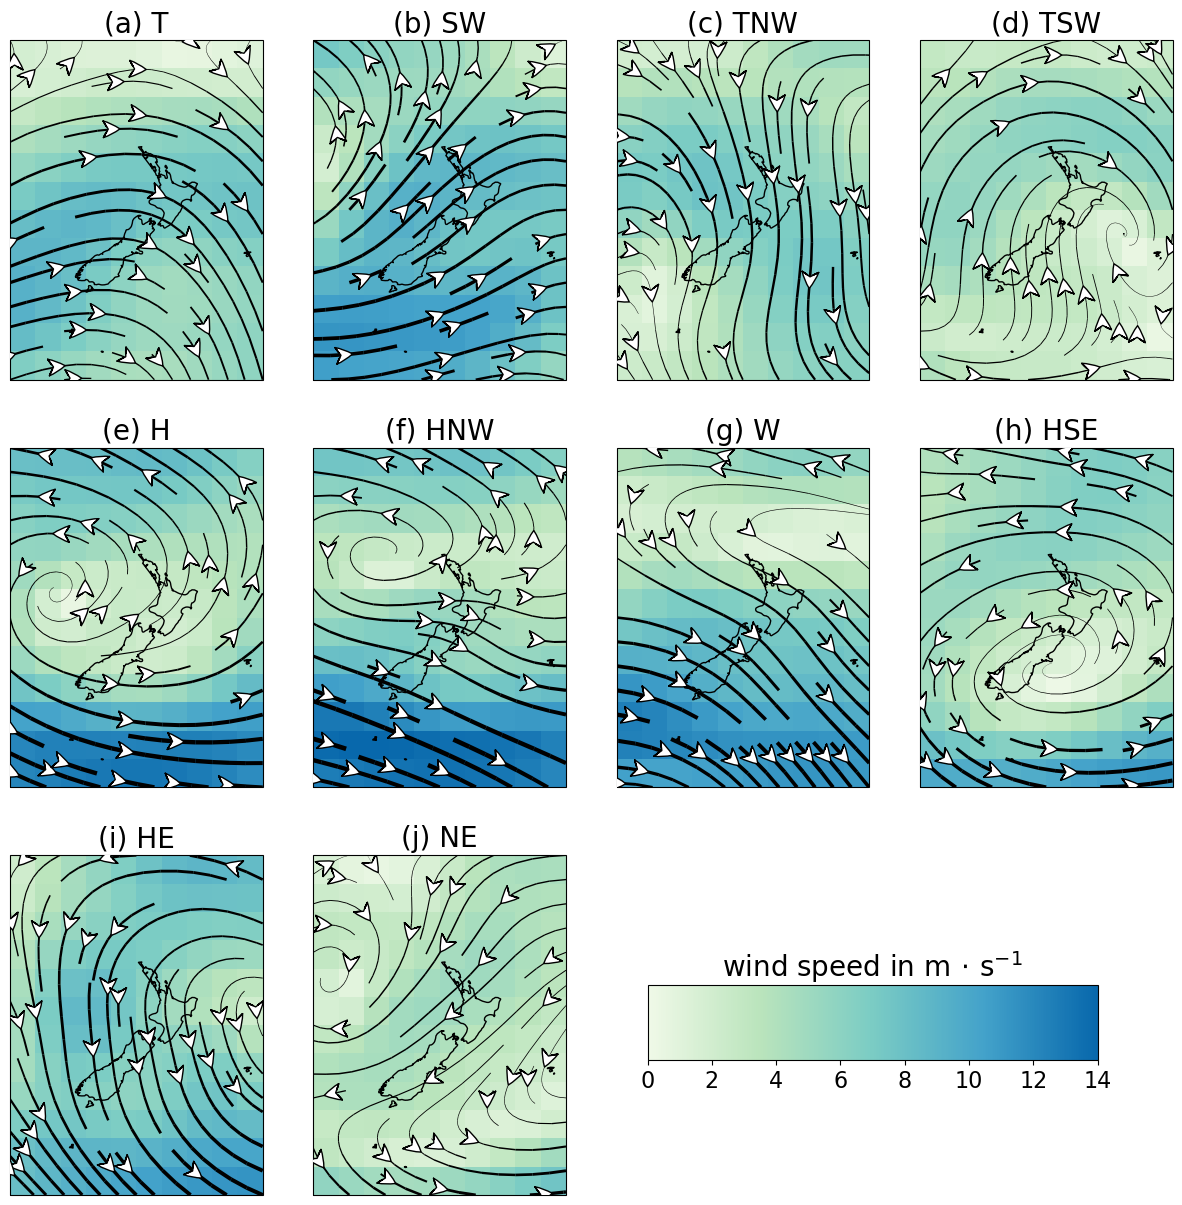

In [2414]:
fig = plt.figure(figsize=[15,15])

letters = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)']


x = uwind_clusters[0].coord('longitude').points
y = uwind_clusters[0].coord('latitude').points

X,Y = np.meshgrid(x,y)

for i in tqdm(range(nclusters - 2)):
    
    ax = fig.add_subplot(3,4, i+1, projection=ccrs.PlateCarree(central_longitude=180), aspect='auto')

    ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs = crs_latlon);
    ax.coastlines();

    speed = np.sqrt(uwind_clusters[i].data**2 + vwind_clusters[i].data**2)

    lw = speed / 4.
 
    color = plt.pcolor(X - 180, Y , speed, vmin = 0, vmax = 14, snap = True, alpha = 1,
                       cmap=palettable.colorbrewer.sequential.GnBu_5.mpl_colormap)

    plt.title(letters[i]+' '+regimes[i], fontsize = 20)    
    
    plt.streamplot(X - 180,Y, uwind_clusters[i].data, vwind_clusters[i].data, linewidth=lw,
                   density = 0.5, arrowstyle = 'Fancy', color = 'k', arrowsize=2)
    
# from https://stackoverflow.com/questions/25349693/change-facecolor-and-edgecolor-of-matplotlib-streamplot-arrows    
# get the axes (note that you should actually capture this when creating the subplot)
    ax = plt.gca()

# iterate through the children of ax
    for art in ax.get_children():
# we are only interested in FancyArrowPatches
        if not isinstance(art, matplotlib.patches.FancyArrowPatch):
            continue
# remove the edge, fill with black
        art.set_edgecolor('k')
        art.set_facecolor('w')
        art.set_linewidth(1)
# make it bigger
        art.set_mutation_scale(30)
# move the arrow head to the front
        art.set_zorder(10)

colorbar_axes = plt.gcf().add_axes([0.55, 0.2, 0.3, 0.05])

cbar = plt.colorbar(color, colorbar_axes, orientation='horizontal', ticks=[0,2,4,6,8,10,12,14])

cbar.ax.tick_params(labelsize=16) 

cbar.ax.set_title(r'wind speed in m$\,\cdot\,$s$^{-1}$', fontsize = 20)

# plt.clim(-0.5, N - 0.5)

plt.savefig('./ncepncar/winds.pdf', dpi=300)

plt.show();

In [2038]:
from mpl_toolkits.axes_grid1.colorbar import colorbar

100%|██████████| 6/6 [00:41<00:00,  6.84s/it]


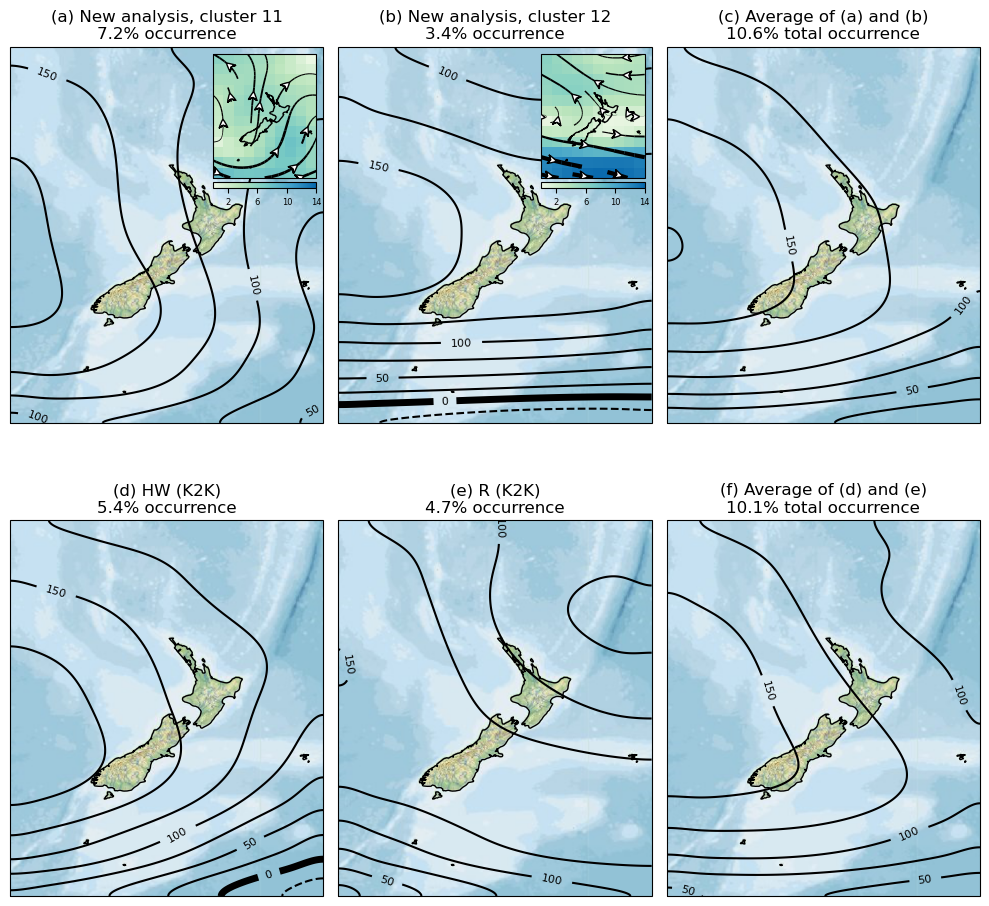

In [2416]:
fig = plt.figure(figsize=[10,10])

titles = ['(a) New analysis, cluster 11','(b) New analysis, cluster 12','(c) Average of (a) and (b)',
          '(d) HW (K2K)','(e) R (K2K)','(f) Average of (d) and (e)']

occurrences = ['\n'+"{:.1f}".format(kmeans_fractions[-2]*100) + '% occurrence',
               '\n'+"{:.1f}".format(kmeans_fractions[-1]*100) + '% occurrence',
               '\n'+"{:.1f}".format(kmeans_fractions[-2]*100 + kmeans_fractions[-1]*100) + '% total occurrence',
               '\n'+"{:.1f}".format(k2k_occurrences[-2]) + '% occurrence',
               '\n'+"{:.1f}".format(k2k_occurrences[-1]) + '% occurrence',
               '\n'+"{:.1f}".format(k2k_occurrences[-2] + k2k_occurrences[-1]) + '% total occurrence']

for i in tqdm(range(6)):
    
    if i == 0:
        plotthis = height_clusters[nclusters - 2]
    if i == 1:
        plotthis = height_clusters[nclusters - 1]
    if i == 2:
        plotthis = (height_clusters[-2] + height_clusters[-1]) / 2.
    if i == 3:
        plotthis = k2k_height_clusters[nclusters - 2]
    if i == 4:
        plotthis = k2k_height_clusters[nclusters - 1]        
    if i == 5:
        plotthis = (k2k_height_clusters[-2] + k2k_height_clusters[-1]) /2.

    ax = fig.add_subplot(2, 3, i + 1, projection=ccrs.PlateCarree(central_longitude=180), aspect='auto')
    ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs = crs_latlon);
    ax.coastlines();

    smooth_contours = True
    if smooth_contours:
        sample_points = [('longitude', np.linspace(lonmin, lonmax, int(longitude.shape[0]*zoomfactor))),
                         ('latitude',  np.linspace(latmax, latmin, int(latitude.shape[0]*zoomfactor)))]

        interpolate = copy.deepcopy(plotthis).interpolate(sample_points, iris.analysis.Linear())
        zoom = scipy.ndimage.zoom(plotthis.data, zoomfactor)
        interpolate.data = zoom.data

        contours = iplt.contour(interpolate, colors = 'k', levels = levels, alpha = 1)
        contours.collections[int(np.array(np.where(levels == 0)))].set_linewidth(5) 
        plt.clabel(contours,contours.levels[::2],  inline=True, fontsize=8, fmt='%d');

    else:
        #new
        contours = iplt.contour(plotthis, levels = levels, alpha = 1, colors = 'k')
        contours.collections[int(np.array(np.where(levels == 0)))].set_linewidth(5) 
        plt.clabel(contours, contours.levels[::2], inline=True, fontsize=8, fmt='%d');

################    

    plt.title(titles[i]+occurrences[i])

    if i < 2:

        axins = inset_axes(ax, width="33%", height="33%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree(central_longitude=180),
                                        aspect='auto'))
        
        axins.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs = crs_latlon);
        axins.coastlines()
        
        if i == 0 :
            thisindex = -2
        elif i ==1:
            thisindex = -1
        
        speed = np.sqrt(uwind_clusters[thisindex].data**2 + vwind_clusters[thisindex].data**2)

        lw = speed /4. 
        
        plt.streamplot(X-180,Y, uwind_clusters[thisindex].data, vwind_clusters[thisindex].data, linewidth=lw,
                       density = 0.25, color = 'k', arrowstyle = 'Fancy', arrowsize=2)
        
        # from https://stackoverflow.com/questions/25349693/change-facecolor-and-edgecolor-of-matplotlib-streamplot-arrows    
# get the axes (note that you should actually capture this when creating the subplot)
#         ax = plt.gca()

# iterate through the children of ax
        for art in plt.gca().get_children():
# we are only interested in FancyArrowPatches
            if not isinstance(art, matplotlib.patches.FancyArrowPatch):
                continue
# remove the edge, fill with black
            art.set_edgecolor('k')
            art.set_facecolor('w')
            art.set_linewidth(1)
# make it bigger
            art.set_mutation_scale(15)
# move the arrow head to the front
            art.set_zorder(10)
        
        
        color = plt.pcolor(X - 180, Y , speed, alpha = 1, vmin = 0, vmax = 14, snap = True,
                  cmap=palettable.colorbrewer.sequential.GnBu_5.mpl_colormap)
        
#         # colorbar
        cax = inset_axes(axins,
                 width="100%",
                 height="5%", 
                 loc='lower left',
                 bbox_to_anchor=(0, -0.08, 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )

        cbar = plt.colorbar(color, cax = cax, orientation = 'horizontal',ticks = [2,6,10,14])
        
        cbar.ax.tick_params(labelsize=6) 

        
#         cbar.ax.set_xticklabels(['','','','','','','',''])
        
#         cbar.yaxis.set_ticks([])
    
        props = dict(boxstyle='round', facecolor='white', alpha=0.9)
#         axins.text(0.95, 0.95, 'wind', transform=axins.transAxes, fontsize=7,
#             verticalalignment='top', horizontalalignment = 'right', bbox=props, color = 'k')
        
        
################    

    ax.background_img(name='plate-carree-wikipedia', resolution='low')

# ax.plot([0.665, 0.665], [0.1, 0.9], color='k', lw=3,
#         transform=plt.gcf().transFigure, clip_on=False, linestyle = '-', alpha = 0.5)    
    
plt.tight_layout()
    
plt.savefig('./ncepncar/newregimes.pdf')    
    
plt.show();
